In [2]:
import os
import ast
import unittest

# preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# import ML libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, LSTM, Input, Lambda, Reshape, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# with inspiration from deeplearning.ai's 'Improvise a Jazz Solo' 
# - https://www.coursera.org/learn/nlp-sequence-models

# Set relative directory paths

In [3]:
DATA_DIR = os.path.join(os.getcwd(), '..', 'data')
DATA_LOOKUPS_DIR = os.path.join(DATA_DIR, 'lookups')
DATA_RAW_DIR = os.path.join(DATA_DIR, 'raw')
DATA_PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
DATA_TRAIN_DIR = os.path.join(DATA_PROCESSED_DIR, 'train')
DATA_TEST_DIR = os.path.join(DATA_PROCESSED_DIR, 'test')
key_chord_mapping = pd.read_csv(os.path.join(DATA_LOOKUPS_DIR, 'musical_key-triad_chord_mapping.csv'), index_col='Degree')

# Filter functions

In [4]:
def filter_sections_by_length(df, t_l, t_h):
    '''
    keep sections from df whose lengths are in set [t_l, t_h] inclusive
    '''
    df['section_length'] = df.chords.apply(len)
    df = df[(df.section_length >= t_l) & (df.section_length <= t_h)]
    
    return df.drop(columns='section_length')


def truncate_sections_by_length(sections, L):
    '''
    truncate sections to length, L
    '''
    
    truncated_sec = []
    for sec in sections:
        truncated_sec.append(sec[:L])
    return truncated_sec


def remove_repeated_chords(sections):
    '''
    for all sections, remove repeated chords
    eg. [1, 1, 4, 5, 5, 1] - > [1, 4, 5, 1]
    '''
    
    sections_filtered = []
    for sec in sections:
        filtered = []
        for i in range(len(sec)):
            if i != 0 and sec[i] != sec[i-1]:
                filtered.append(sec[i])
            elif i == 0:
                filtered.append(sec[i])
        sections_filtered.append(filtered)

    return pd.Series(sections_filtered)

    
def remove_duplicate_sections(df):
    '''
    remove duplicate sections for each song
    '''
    song_ids = df.id.unique()
    df_unique = pd.DataFrame()
    df.chords = df.chords.apply(str)
    for i in song_ids:
        sec = df[df.id == i].chords.unique()
        song_id_array = [i] * len(sec)
        data = {'song_id': song_id_array, 'chords': sec}
        df_unique = df_unique.append(pd.DataFrame(data))
    df_unique.chords = df_unique.chords.apply(ast.literal_eval)
    
    return df_unique


def extend_section_lengths(sections, L):
    '''
    extends chords in series to length, L
    sections, s, will be repeated and truncated at length l
    '''
    long_sections = []
    for s in sections:
        long_sec = []
        if len(s) == 0:
            continue
        while len(long_sec) < L:
            long_sec.extend(s)
        long_sections.append(long_sec[:L])
        
    return pd.Series(long_sections)

# Preprocessing for ML

In [5]:
# Begin using chords_by_section dataframe from Module 02
df = pd.read_csv(os.path.join(DATA_RAW_DIR, 'chords_by_section.csv'), index_col='Unnamed: 0')

# Extract useful columns and format
df = df[['id', 'chords_numeric']]
df.rename(columns={'chords_numeric': 'chords'}, inplace=True)  # only one chord column here, so rename
df.chords = df.chords.apply(ast.literal_eval)  # convert from str to list

MIN_SECTION_LENGTH = 4  # chord sequences must be above this threshold
MAX_SECTION_LENGTH = 100  # chord sequences must be below this threshold
df = filter_sections_by_length(df, MIN_SECTION_LENGTH, MAX_SECTION_LENGTH)
df.chords = truncate_sections_by_length(df.chords, MAX_SECTION_LENGTH)
df.reset_index(inplace=True)
df.chords = remove_repeated_chords(df.chords)
df = remove_duplicate_sections(df)

#### Experimenting with unit tests


In [6]:
class UnitTests(unittest.TestCase):
    
    def test_remove_repeated_chords(self):
        # Input; Output
        # Add test cases here and append to data
        t1 = {'input': [1,1,1,1], 'output': [1]}
        t2 = {'input': [1,1,1,1,6,6], 'output': [1,6]}
        t3 = {'input': [1,1,1,1,6,6,1], 'output': [1,6,1]}
        t4 = {'input': [5,4,5,5,6,5], 'output': [5,4,5,6,5]}
        t5 = {'input': [6,5,4,4], 'output': [6,5,4]}
        data = [t1,t2,t3,t4,t5]
        tdf = pd.DataFrame(data=data)
        
        # call to function being tested
        test_output = remove_repeated_chords(tdf.input)
        test_output.rename('output', inplace=True)
        
        # check output
        pd.testing.assert_series_equal(test_output, tdf.output)

unittest.main(argv=[''], verbosity=2, exit=False);

test_remove_repeated_chords (__main__.UnitTests) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.004s

OK


#### Check lengths

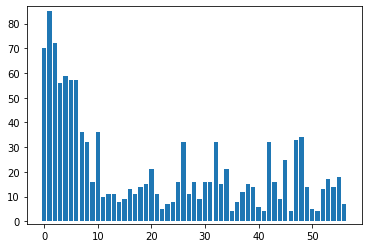

In [7]:
df['section_length'] = df.chords.apply(len)
plt.figure();
plt.ylim(ymax=max(df.section_length) + 2, ymin=min(df.section_length) - 2);
plt.bar(df.index, df.section_length);
df.drop(columns='section_length', inplace=True);

In [8]:
df.describe()

,song_id
count,1.228000e+04
mean,8.870467e+05
std,7.413886e+05
min,2.920000e+02
25%,1.948150e+05
50%,7.868910e+05
75%,1.229198e+06
max,3.732140e+06


In [9]:
def chord_number_to_one_hot(num):
    return tf.one_hot(num-1, depth=7).numpy()
    

def chord_sequence_to_one_hot(seq):
    return tf.one_hot([c-1 for c in seq], depth=7).numpy()


def move_first_timestep_to_end(y):
    '''
    take entry at t = 0 and move from start to end of array
    this makes it easy to feed data into ML model later (as x<t+1> = y<t>)
    '''
    a = y[0, :]
    a = np.resize(a, (1, len(a)))
    b = y[1:, :]
    y = np.concatenate((a, b))
    
    return y

In [10]:
TRAINING_SEQUENCE_LENGTH = 8
df.chords = extend_section_lengths(df.chords, TRAINING_SEQUENCE_LENGTH)
df = df.reset_index().drop(columns='index')

shape_X = (len(df.chords), TRAINING_SEQUENCE_LENGTH, 7)  # 7 choices for chord type
shape_Y = (TRAINING_SEQUENCE_LENGTH, len(df.chords), 7)
X = np.zeros(shape_X)
Y = np.zeros(shape_Y)

for index, chords in enumerate(df.chords):
    x = chord_sequence_to_one_hot(chords)
    y = move_first_timestep_to_end(x)
    X[index, :, :] = x
    Y[:, index, :] = y

m = X.shape[0]  # training examples
Tx = X.shape[1]  # Training sequence length
n = X.shape[2]   # number of output classes, each chord can be a number [1-7]
Ty = Y.shape[0]  # Prediction sequence length

# Building models

In [11]:
n_a = n*4
# cells trained by below model
reshapor = Reshape((1, n))
lstm = LSTM(n_a, return_state=True)
d1 = Dense(4*n, activation='relu')
d2 = Dense(2*n, activation='relu')
densor = Dense(n, activation='softmax')

def create_model(Tx, n_a, n):
    '''
    Tx: Length of chord sequence
    n_a: Number of activations in hidden layers
    n: number of unique outputs for chords
    '''
    X = Input(shape=(Tx, n), name = 'X')
    a0 = Input(shape=(n_a,), name='a0')  # initial activations
    c0 = Input(shape=(n_a,), name='c0')  # initial cell state
    a = a0  # copy to 'a' as 'a' be updated after each timestep t in Tx, don't override a0
    c = c0  # copy to 'c' as 'c' will be updated after each timestep t in Tx, don't override c0
    outputs = []
    
    for t in range(Tx):
        
        # extract all one-hot chord vector at timestep t, for entire batch provided to model
        x = Lambda(lambda z: z[:, t, :]) (X)
        # change shape
        x = reshapor(x)
        # pass through lstm cell once, update activation and cell state values
        a, _, c = lstm(inputs=x, initial_state=[a, c])
        # pass through fully-connected layer
        
        yhat = densor(d2(d1(a)))
        # collect outputs
        outputs.append(yhat)
        
    # create model now that input-output map has been generated
    # initialise activations and cell state
    return Model(inputs=[X, a0, c0], outputs=outputs)

In [12]:
model = create_model(Tx=Tx, n_a=n_a, n=n)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 8, 7)]       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 7)            0           X[0][0]                          
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 7)         0           lambda[0][0]                     
                                                                 lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
                                                                 lambda_3[0][0]               

In [13]:
opt = Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])  # metric

# Train model

In [14]:
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))
model.fit([X, a0, c0], list(Y), epochs=10)

Epoch 1/10
384/384 [==============================] - 9s 5ms/step - loss: 4.9430 - dense_2_loss: 0.3037 - dense_2_1_loss: 0.4454 - dense_2_2_loss: 0.5839 - dense_2_3_loss: 0.6983 - dense_2_4_loss: 0.8121 - dense_2_5_loss: 0.6425 - dense_2_6_loss: 0.7841 - dense_2_7_loss: 0.6730 - dense_2_accuracy: 0.9208 - dense_2_1_accuracy: 0.8121 - dense_2_2_accuracy: 0.7798 - dense_2_3_accuracy: 0.7856 - dense_2_4_accuracy: 0.7537 - dense_2_5_accuracy: 0.7886 - dense_2_6_accuracy: 0.7067 - dense_2_7_accuracy: 0.5996
Epoch 2/10
384/384 [==============================] - 2s 5ms/step - loss: 2.8376 - dense_2_loss: 0.1989 - dense_2_1_loss: 0.2220 - dense_2_2_loss: 0.2998 - dense_2_3_loss: 0.4049 - dense_2_4_loss: 0.5448 - dense_2_5_loss: 0.4352 - dense_2_6_loss: 0.4419 - dense_2_7_loss: 0.2900 - dense_2_accuracy: 0.9519 - dense_2_1_accuracy: 0.9504 - dense_2_2_accuracy: 0.9195 - dense_2_3_accuracy: 0.8814 - dense_2_4_accuracy: 0.8601 - dense_2_5_accuracy: 0.8780 - dense_2_6_accuracy: 0.9151 - dense_2_7

In [15]:
def one_hot(x, depth):
    x = K.argmax(x)
    x = tf.one_hot(indices=x, depth=depth) 
    x = RepeatVector(1)(x)
    return x


def make_inference_model(lstm_cell, densor, n, n_a, Ty):
    '''
    produce inference model from trained inputs
    
    lstm: a trained LSTM cell
    densor: a trained Dense + Activation layer
    n: number of possible chords
    n_a: number of units in lstm
    Ty: length of output sequence to generate
    '''
    
    # initialise shapes
    x0 = Input(shape=(1, n), name='x0')
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    outputs = []
    
    for t in range(Ty):
        
        # pass x<t> into LSTM and update activation and cell state values
        a, _, c = lstm(inputs=x, initial_state=[a, c])
        
        # pass through trained fully-connected layer
        yhat = densor(d2(d1(a)))

        # collect predictions
        outputs.append(yhat)
        
        # convert output yhat<t> to one-hot representation (using argmax) and set as x<t+1>
        x = Lambda(lambda z : one_hot(z, depth=n))(yhat)
        
    # create inference model 
    # difference between inference_model and the last model is that inference_model feeds
    # the LSTM cell output in as the next input
    return Model(inputs=[x0, a0, c0], outputs=outputs)

In [16]:
GENERATED_SEQUENCE_LENGTH = 8
inference_model = make_inference_model(lstm, densor, n=n, n_a=n_a, Ty=GENERATED_SEQUENCE_LENGTH)
inference_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x0 (InputLayer)                 [(None, 1, 7)]       0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 [(None, 28)]         0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 [(None, 28)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 28), (None,  4032        x0[0][0]                         
                                                                 a0[0][0]                   

In [17]:
def generate_chord_sequence(inference_model, x_init, a_init, c_init):
    '''
    generate a chord sequence of length Ty, according to inference_model,
    where Ty is output sequence length
    '''
    
    # generate array of decimals (activations)
    # shape (Ty, 7)
    prediction = inference_model.predict([x_init, a_init, c_init])
    
    # transform array by replacing them with the index (chord number - 1) of the corresponding maximum entry
    # shape (Ty, 1)
    indices = np.array(prediction).argmax(axis=-1)

    # convert array to corresponding chord outputs and flatten into list
    # shape (Ty, 1)
    sequence = map_to_chord_numbers(indices)
    
    return sequence
 

def map_to_chord_numbers(a):
    '''
    convert array of indices to their corresponding chord number
    '''
    return (a + 1).flatten().tolist()


def degrees_to_chords(degrees, key='random'):  ##TODO + length of gen seq independent to training len\n",
    '''
    maps scale degrees to chords in in key provided
    '''
    
    if key == 'random':  # select random key as none was provided
        key = random.choice(key_chord_mapping.columns)
    
    chords_in_key = key_chord_mapping[key]
    chords = [chords_in_key[d] for d in degrees]
    
    return chords

# Generate (predict) a sequence

In [37]:
NUM_SEQUENCES = 1
seqs = []
i = 0
while i < NUM_SEQUENCES:
    
    x_init = np.random.rand(1, 1, n)
    a_init = np.random.rand(1, n_a)*0
    c_init = np.random.rand(1, n_a)*0

    s = generate_chord_sequence(inference_model, x_init, a_init, c_init)
    
    if s not in seqs:
        i = i + 1
        seqs.append(s)
    
print(seqs)
key = 'E'
chords = [degrees_to_chords(s, key=key) for s in seqs]
print(f'key: {key}')
print(chords)

[[1, 4, 5, 4, 5, 4, 5, 1]]
key: E
[['E', 'A', 'B', 'A', 'B', 'A', 'B', 'E']]


In [19]:
filename_inference_model = 'model'
MODEL_PATH = os.path.join('.', filename_inference_model)
inference_model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: .\model_chord_progression_generator\assets


INFO:tensorflow:Assets written to: .\model_chord_progression_generator\assets


In [20]:
# Load and check it works
x_init = np.random.rand(1, 1, n)
loaded_model = load_model(MODEL_PATH)
generate_chord_sequence(loaded_model, x_init, a_init, c_init)

[1, 6, 1, 6, 5, 1, 6, 1]

In [19]:
# Extension: Making it more interesting

In [20]:
# Model only spitting out 1,4,5,6 chords, makes sense....Change data, then regenerate

In [21]:
# First, some theory: #TODO INSERT CHORD TENSION TABLES
# Tonic: I -> iii
# Subdominant: IV, vi -> ii
# Dominant: V -> dim